# DDSM Breast Cancer

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import os.path
import pandas as pd

In [3]:
bs = 8
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [4]:
%pwd

'D:\\FastaiV3\\nbs\\dl1'

In [5]:
path = Path('data/ddsm'); 
path

WindowsPath('data/ddsm')

In [6]:
labels = Path('data/ddsm/ddsm_labels/3class'); 
labels

WindowsPath('data/ddsm/ddsm_labels/3class')

In [7]:
path.ls()

[WindowsPath('data/ddsm/ddsm_labels'),
 WindowsPath('data/ddsm/images'),
 WindowsPath('data/ddsm/models')]

In [8]:
labels.ls()

[WindowsPath('data/ddsm/ddsm_labels/3class/test.txt'),
 WindowsPath('data/ddsm/ddsm_labels/3class/train.txt'),
 WindowsPath('data/ddsm/ddsm_labels/3class/val.txt')]

In [9]:
df = pd.read_csv(labels/'val.txt', sep=" ", header=None)
df.columns = ["file_path", "label"]

In [10]:
df.replace(to_replace={0: 0, 1: 1, 2: 1}, inplace=True) # reset to correct two different labels

In [11]:
NUMBER = 1000

In [12]:
df_tumor = df.loc[df['label'] == 1] # take malignant patches

In [13]:
df_tumor = df_tumor[:NUMBER]

In [14]:
df_normal = df.loc[df['label'] == 0] # take malignant patches

In [15]:
df_normal = df_normal[:NUMBER]

In [16]:
# df = df.sample(frac=1).reset_index(drop=True) # shuffle

In [17]:
df = df_tumor.append(df_normal, ignore_index=True)

In [18]:
len(df)

2000

In [19]:
df.head()

AttributeError: 'LazyConfigValue' object has no attribute 'lower'

                                           file_path  label
0  images/168/benign_01-B_3099_1.LEFT_CC.LJPEG.1-...      1
1  images/420/benign_01-B_3099_1.LEFT_CC.LJPEG.1-...      1
2  images/326/benign_01-B_3099_1.LEFT_CC.LJPEG.1-...      1
3  images/171/benign_01-B_3099_1.LEFT_CC.LJPEG.1-...      1
4  images/243/benign_01-B_3099_1.LEFT_MLO.LJPEG.1...      1

In [20]:
data = ImageDataBunch.from_df(path, df, ds_tfms=get_transforms(), size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (1600 items)
[Category 1, Category 1, Category 1, Category 1, Category 1]...
Path: data\ddsm
x: ImageItemList (1600 items)
[Image (3, 227, 227), Image (3, 227, 227), Image (3, 227, 227), Image (3, 227, 227), Image (3, 227, 227)]...
Path: data\ddsm;

Valid: LabelList
y: CategoryList (400 items)
[Category 1, Category 1, Category 1, Category 0, Category 1]...
Path: data\ddsm
x: ImageItemList (400 items)
[Image (3, 227, 227), Image (3, 227, 227), Image (3, 227, 227), Image (3, 227, 227), Image (3, 227, 227)]...
Path: data\ddsm;

Test: None

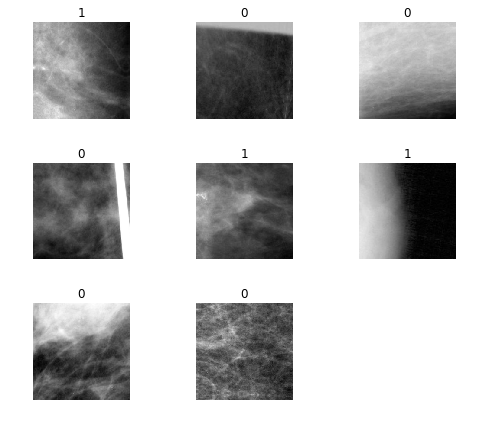

In [145]:
data.show_batch(rows=3, figsize=(7,6))

In [146]:
print(data.classes)
print(data.c)

[0, 1]
2


## Training: resnet34

In [21]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [22]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [149]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.816006,0.759674,0.355000
2,0.672429,0.580231,0.310000
3,0.636778,0.532808,0.275000
4,0.587695,0.519842,0.252500


In [150]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [151]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

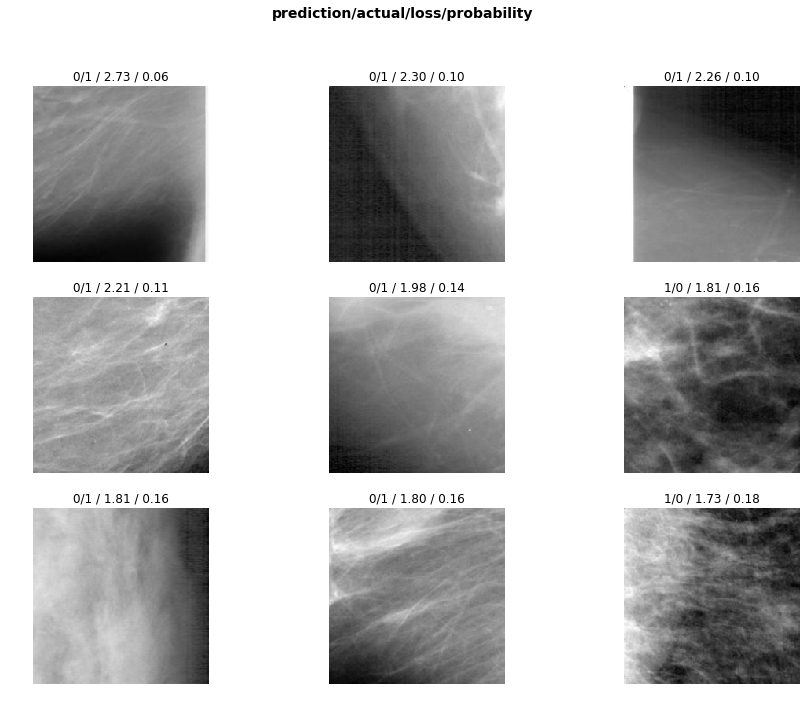

In [152]:
interp.plot_top_losses(9, figsize=(15,11))

In [153]:
doc(interp.plot_top_losses)

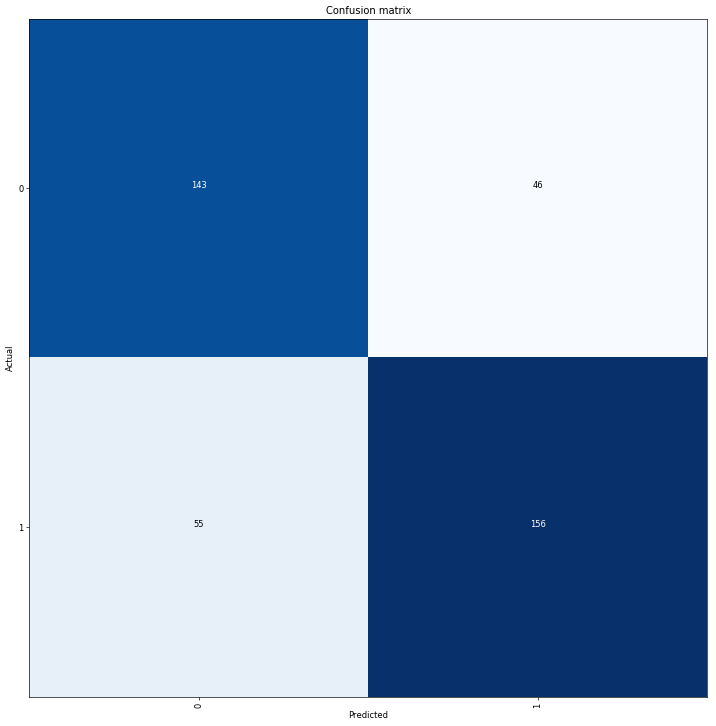

In [154]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [155]:
interp.most_confused(min_val=2)

[(1, 0, 55), (0, 1, 46)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [156]:
learn.unfreeze()

In [157]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.640010,0.576802,0.287500


In [158]:
learn.load('stage-1');

In [159]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


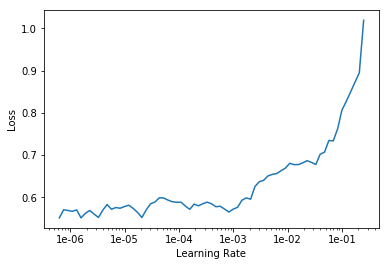

In [160]:
learn.recorder.plot()

In [161]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.604405,0.536758,0.277500
2,0.521496,0.515276,0.257500


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [23]:
data = ImageDataBunch.from_df(path, df, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

In [24]:
learn = create_cnn(data, models.resnet152, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


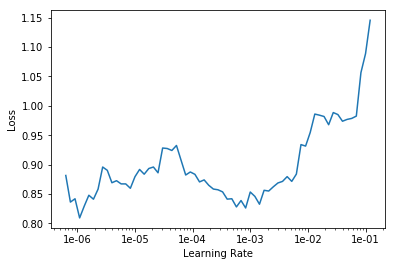

In [164]:
learn.lr_find()
learn.recorder.plot()

In [165]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.843179,0.736602,0.337500
2,0.696610,0.646028,0.335000
3,0.644189,0.613979,0.320000
4,0.579614,0.549764,0.275000
5,0.548228,0.510319,0.257500
6,0.528280,0.489307,0.210000
7,0.521216,0.480444,0.222500
8,0.480097,0.467135,0.217500


In [166]:
learn.save('stage-1-152')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [167]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.516924,0.456017,0.210000
2,0.449006,0.452480,0.212500


If it doesn't, you can always go back to your previous model.

In [30]:
learn.load('stage-1-152');

In [ ]:
learn.fit_one_cycle(18, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.466538,0.390108,0.175000
2,0.552196,0.497410,0.215000
3,0.561088,0.518279,0.252500
4,0.662306,0.839875,0.420000
5,0.656409,0.561181,0.287500
6,0.619873,0.882666,0.475000
7,0.598987,1.525340,0.340000
8,0.565502,0.537290,0.267500


In [27]:
learn.save('stage-1-152')

In [28]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.472892,0.379754,0.175000
2,0.443814,0.384094,0.177500
3,0.447805,0.375964,0.167500
4,0.482111,0.378568,0.167500
5,0.497279,0.385967,0.170000
6,0.460262,0.385607,0.167500
7,0.452574,0.374246,0.162500
8,0.477616,0.378337,0.167500


In [29]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.506874,0.479787,0.222500
2,0.487602,0.390199,0.190000


In [169]:
interp = ClassificationInterpretation.from_learner(learn)

In [170]:
interp.most_confused(min_val=2)

[(1, 0, 53), (0, 1, 32)]